# Crime Prediction using Tweets and KDE

In [2]:
%matplotlib inline

import os
import glob
import functools

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

In [3]:
CHICAGO_COORDS = {'ll': {'longitude': -87.94011, 'latitude': 41.64454}, # Lower Left Corner 
                  'ur': {'longitude': -87.52413, 'latitude': 42.02303}} # Upper Right Corner

TRAIN_STRART_DATE = '2017-12-21'
TRAIN_END_DATE = '2018-01-21'
TEST_STRART_DATE = '2018-01-22'
TEST_END_DATE = '2018-02-22'

CRIME_TYPE = 'THEFT'

GEO_CELL_SIZE = 1000 #meter
N_LATITUDE_CELLS = 35
N_LONGITUDE_CELLS = 42


In [32]:
import imp
import utils.geo
from utils.geo import enrich_with_grid_coords, \
                        filter_by_geo_coord
imp.reload(utils.geo)
enrich_with_chicago_grid_1000 = functools.partial(utils.geo.enrich_with_grid_coords,
                                                 bounderies=CHICAGO_COORDS,
                                                 cell_size=GEO_CELL_SIZE)

filter_by_chicago_coord = functools.partial(utils.geo.filter_by_geo_coord,
                                            bounderies=CHICAGO_COORDS)


![title](./ANLP-Project-Pipeline.png)

## Data Sources

### Chicago Crimes Incidents

#### Load original data

In [213]:
crimes_data = pd.read_csv('./data/[180217]Crimes_-_2001_to_present.csv')

#### Prepare columns

In [214]:
crimes_data = crimes_data[['Date', 'Primary Type', 'Latitude', 'Longitude']]
crimes_data = crimes_data.rename(index=str,
                                 columns={'Date'        : 'timestamp',
                                          'Primary Type': 'type',
                                          'Latitude'    : 'latitude',
                                          'Longitude'   : 'longitude'})

In [215]:
CHICAGO_CRIME_DATA_TIMESTAMP_FORMAT = '%m/%d/%Y %H:%M:%S %p'

crimes_data['timestamp'] = pd.to_datetime(
    crimes_data['timestamp'],
    format=CHICAGO_CRIME_DATA_TIMESTAMP_FORMAT
)

#### Filter relavent crimes for the research time window

In [216]:
crimes_data = crimes_data[(crimes_data['timestamp'] >= TRAIN_STRART_DATE) &
                          (crimes_data['timestamp'] <= TEST_END_DATE)]

#### Filter tweets to be exactly inside chicago box

In [307]:
crimes_data = filter_by_chicago_coord(crimes_data)

#### Crimes Types Histogram

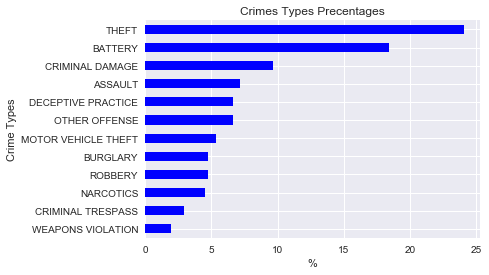

In [217]:
crime_types_probs = crimes_data['type'].value_counts(normalize=True, ascending=True)
crime_types_precents = crime_types_probs * 100
crime_types_precents = crime_types_precents[crime_types_precents > 1]
crime_types_precents.astype(int)
crime_types_precents.plot(kind='barh', color='blue')
plt.title('Crimes Types Precentages')
plt.xlabel('%')
plt.ylabel('Crime Types')
plt.xticks(range(0, 30, 5))
None

#### Filter crime types (only THEFT, the most common crime)

In [218]:
crimes_data = crimes_data[crimes_data['type'] == CRIME_TYPE]
crimes_data = crimes_data[['timestamp', 'latitude', 'longitude']]

In [219]:
crimes_data.head()

,timestamp,latitude,longitude
1858,2018-02-04 11:00:00,41.769953,-87.628286
2901,2018-02-04 10:00:00,41.799876,-87.603929
3075,2018-02-04 09:30:00,41.933941,-87.645807
3225,2018-02-04 10:00:00,41.793263,-87.642699
3269,2018-02-04 10:00:00,41.722578,-87.662707


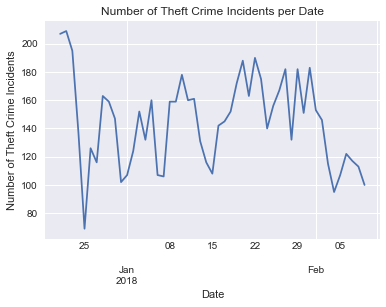

In [272]:
(pd.Series(np.ones(len(crimes_data)), index=crimes_data['timestamp'])
 .resample('D')
 .sum()
 .plot())

plt.title('Number of Theft Crime Incidents per Date')
plt.xlabel('Date')
plt.ylabel('Number of Theft Crime Incidents')
None



#### Enrich with cells indicies

In [318]:
crime_data = enrich_with_chicago_grid_1000(crimes_data)

35


In [309]:
crime_data.head()

,timestamp,latitude,longitude,latitude_index,longitude_index,cell_index
1858,2018-02-04 11:00:00,41.769953,-87.628286,26,13,572
2901,2018-02-04 10:00:00,41.799876,-87.603929,28,16,700
3075,2018-02-04 09:30:00,41.933941,-87.645807,24,31,1326
3225,2018-02-04 10:00:00,41.793263,-87.642699,24,16,696
3269,2018-02-04 10:00:00,41.722578,-87.662707,23,8,359


### Tweets

#### Load raw tweets data

In [10]:
#tweets_csv_dtype={''}

tweets_data = pd.concat(
    (pd.read_csv(path) for path in tqdm_notebook(glob.glob('./data/tweets-*.csv')))
)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (0,1,9,19,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,14,19,20,21,24,29,30,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


#### Remove duplicated tweets due to collections problems

In [14]:
tweets_data = tweets_data.drop_duplicates(subset=['id'])

#### Remove tweets without geo-coordinates

In [15]:
tweets_data = tweets_data.dropna(subset=['geo'])

#### Extract Latitude & Longtitude

In [31]:
import json

def extract_tweets_latlng(tweet):
    raw_coord_json = tweet['geo'].replace("'", '"')
    coordinates = json.loads(raw_coord_json)['coordinates']
    return pd.Series({'latitude' : coordinates[0],
                      'longitude': coordinates[1]})

tweets_data = pd.concat([tweets_data,
                  tweets_data.apply(lambda tweet: extract_tweets_latlng(tweet), axis=1)],
              axis=1)

#### Select relavent colums

In [33]:
tweets_data = tweets_data[['id', 'created_at', 'latitude', 'longitude', 'text']]          

#### Filter tweets to be exactly inside chicago box

In [34]:
tweets_data = filter_by_chicago_coord(tweets_data)

#### Enrich with cells indicies

In [35]:
tweets_data = enrich_with_chicago_grid_1000(tweets_data)

In [37]:
tweets_data

Index(['id', 'created_at', 'latitude', 'longitude', 'text', 'latitude_index',
       'longitude_index', 'cell_index'],
      dtype='object')

## Data Preprocessing

### Tokenizer

In [38]:
from utils.twokenize3 import tokenizeRawTweetText

In [39]:
tweets_data['tokens'] = tweets_data['text'].apply(tokenizeRawTweetText)

### Sub-grouping by Geo-Location

In [68]:
docs_groupby = tweets_data.groupby(('cell_index', 'latitude_index', 'longitude_index'))
docs = docs_groupby['tokens'].apply(lambda r : list(r))
docs = docs.sort_index()

In [79]:
docs.apply(lambda r: len(r))
np.zeros((N_))

cell_index  latitude_index  longitude_index
7           7               0                    1
16          16              0                   12
21          21              0                   20
25          25              0                    1
27          27              0                    1
28          28              0                    1
32          32              0                    1
46          11              1                    1
48          13              1                    3
50          15              1                    5
55          20              1                    2
56          21              1                   11
57          22              1                    1
58          23              1                   24
63          28              1                    1
66          31              1                    1
67          32              1                    1
79          9               2                    5
80          10              2         

## Feature Extracts

### KDE

In [1]:
# A function that gets crime_data -> trained KDE object
# take DataFrame[latitude, longtitude]

def getKDEModel(train_df):
    """ This function generates KDE model.
    
        Input:
        train_df: train data frame with Latitude Logitude. 3 months prior data for the day of surveillance..
        
        Output:
        KDE Model
    """
    kde = KernelDensity(bandwidth=0.00017, metric='haversine',kernel='gaussian', algorithm='ball_tree')
    kde.fit(train_df[['Latitude','Longitude']])
    return kde

### Sentiment Analysis

### LDA

In [6]:
td = [["this is not a tweet".split(), "tweeter soks :)".split(), "I do not want to party :/".split()],["#creizi yeee".split(), "shooting outside!".split()],["where am i?".split(), "this is not a drill, please do NOT drink milk".split()]]
print(td)

[[['this', 'is', 'not', 'a', 'tweet'], ['tweeter', 'soks', ':)'], ['I', 'do', 'not', 'want', 'to', 'party', ':/']], [['#creizi', 'yeee'], ['shooting', 'outside!']], [['where', 'am', 'i?'], ['this', 'is', 'not', 'a', 'drill,', 'please', 'do', 'NOT', 'drink', 'milk']]]


In [102]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import itertools

def coalesce(token):
    new_tokens = []
    for char in token:
        if len(new_tokens) < 2 or char != new_tokens[-1] or char != new_tokens[-2]:
            new_tokens.append(char)
    return ''.join(new_tokens)

def preprocess(text):
    # text input is one string
    # output is tokenized and preprocessed(as defined below) text
    
    # lowercase
    # no hashtags or mentions
    # any url converted to "url"
    # replace multiple repeated chars with 2 of them. eg paaaarty -> paarty
        
    tokens = []
    for token in text:
        if token.startswith("@") or token.startswith("#"):
            continue
        elif token.startswith("https://") or token.startswith("http://"):
            tokens.append(u"url")
        else:
            tokens.append(coalesce(token))
            
    return tokens

def process_documents_lda(docs):
    # assume a document is a list of tweets
    # join tweets in a document by whitespace
    #for d in docs:
    #    print(list(itertools.chain.from_iterable(d)))
    return [list(itertools.chain.from_iterable(d)) for d in docs]

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " | ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def learn_lda(tweet_docs, preprocess=preprocess, tokenizer=lambda x:x, topic_amount=500):
    
    docs = process_documents_lda(tweet_docs)
    
    vectorizer = CountVectorizer(stop_words="english", preprocessor=preprocess, tokenizer=tokenizer)

    X = vectorizer.fit_transform(docs)

    lda = LatentDirichletAllocation(n_components=topic_amount,
                                    max_iter=10,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=42,
                                    verbose=1)

    lda.fit(X)
    
    print_top_words(lda, vectorizer.get_feature_names(), 10)
    
    return lda

In [103]:
lda = learn_lda(docs.tolist())


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic #0: url | , | … | IL | : | . | Chicago | ! | - | ?
Topic #1: runway | WOODLAWN | Bazarcito | saturday | enjoys | Skool | Melter | techniques | EARR | Install
Topic #2: Greatest | 20797 | Endurance | 6705 | Conversation🗣 | 💇 | Sunset | Jams | Tinga | 11:47
Topic #3: Analyst/Human | LATEST | 🚨FUCKING | COMING | Wes | disappointment | Made | Jump | Gains | Glinda
Topic #4: Homewood-Flossmoor | Repair | DONUTS | Floyds | Coolin | 10634 | Chillen | Ernesto | Michael | nerf
Topic #5: Pharmacology | grandpa | Slide | Whistler | Maria | result | chili | 👍🐟✌🏼 | Venkata | a.k.a.
Topic #6: -> | wind | temperature | humidity | , | Oak | : | Lawn | pressure | clouds
Topic #7: hash | ALTHOUGH | 🙌🏽💯🙌🏽 | wonto

In [84]:
q = docs.tolist()

In [95]:
lda.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': 1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

## Model Training & Evaluation

### Training

### Evaluation